In [1]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]
#sns.set_style("whitegrid")

## Data Import

In [2]:
import scipy.io as sio
matfile = sio.loadmat(r"data\cars_annos.mat")

In [3]:
# get the keys of this dictionary
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [4]:
matfile['annotations'][0]

array([(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       ...,
       (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
       (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([[60]],

In [5]:
data = [[row.flat[0] for row in line] for line in matfile['annotations'][0]]

columns = ["filename", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "test"]

df = pd.DataFrame(data, columns=columns)

In [6]:
df.head()

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,0
1,car_ims/000002.jpg,48,24,441,202,1,0
2,car_ims/000003.jpg,7,4,277,180,1,0
3,car_ims/000004.jpg,33,50,197,150,1,0
4,car_ims/000005.jpg,5,8,83,58,1,0


In [7]:
# drop the bounding box information, because we are only applying normal image classification
df = df.drop(columns=["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"])

In [8]:
df.head()

,filename,class,test
0,car_ims/000001.jpg,1,0
1,car_ims/000002.jpg,1,0
2,car_ims/000003.jpg,1,0
3,car_ims/000004.jpg,1,0
4,car_ims/000005.jpg,1,0


In [9]:
# remove the folder car_ims from the filenames to only have the filename
df["filename"] = df["filename"].apply(lambda x: x.replace("car_ims/", ""))
df.head()

,filename,class,test
0,000001.jpg,1,0
1,000002.jpg,1,0
2,000003.jpg,1,0
3,000004.jpg,1,0
4,000005.jpg,1,0


In [10]:
# check unique values and get number of classes
for column in df.columns:
    print(f"Column {column} contains {df[column].unique().shape[0]} unique values. { 100 * df[column].unique().shape[0] / df[column].shape[0]}% of total data. \n")

Column filename contains 16185 unique values. 100.0% of total data. 

Column class contains 196 unique values. 1.2109978375038617% of total data. 

Column test contains 2 unique values. 0.01235712079085573% of total data. 



There are in total 196 different classes available. Let's now check how many of the images are used for testing.

In [11]:
num_images = df.shape[0]
num_test = np.sum(df["test"] == 1)
print(f"There are {num_images} images in this dataset.")
print(f"{num_test} of these images are in the test set ({100 * num_test / num_images}% of total data).")

There are 16185 images in this dataset.
8041 of these images are in the test set (49.68180413963547% of total data).


In [12]:
# get the class names
class_names = [[row.flat[0] for row in line] for line in matfile['class_names'][0]]

In [13]:
class_names = [class_names[idx][0] for idx in range(len(class_names))]

## EDA

Let's first check the shape of the images. For this, let's load some images into numpy arrays and check the shapes. For this, I only want to check the shapes of the first images in order to check whether they are of equal size or not. If not, then different images sizes are to be tested for the final model and the best performing shall be used in the end.

In [14]:
from PIL import Image

def files_to_numpy(df, folder):
    list_of_files = df["filename"][:20].to_list()
    
    # read data into numpy array
    for img_file in list_of_files:
        image = np.array(Image.open(os.path.join(folder, img_file) ))
        print(image.shape)

In [15]:
files_to_numpy(df, r"data\car_ims")

(768, 1024, 3)
(219, 460, 3)
(233, 310, 3)
(188, 250, 3)
(64, 85, 3)
(111, 250, 3)
(176, 464, 3)
(85, 113, 3)
(276, 300, 3)
(111, 148, 3)
(72, 96, 3)
(100, 160, 3)
(179, 300, 3)
(120, 160, 3)
(71, 94, 3)
(93, 124, 3)
(91, 160, 3)
(525, 700, 3)
(272, 450, 3)
(439, 700, 3)


Okay. Seems like there are a lot of different images sizes available. Let's later check different images sizes and train models on them in order to find the best suited. In addition, let's convert the images into grayscale images later, because this should be sufficient for a cars classifier. <br> <br>
Let's now take a look into some images.

In [16]:
def show_image(df, folder, index, classes=class_names):
    filename = os.path.join(folder, df["filename"][index])
    class_name = classes[df["class"][index]]
    
    image = plt.imread(filename)
    plt.title(class_name)
    plt.imshow(image)

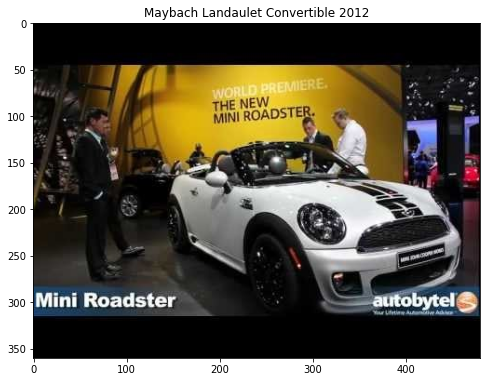

In [17]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

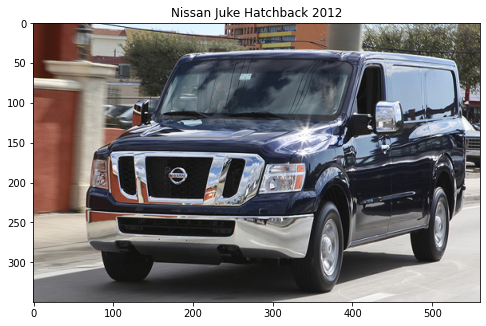

In [18]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

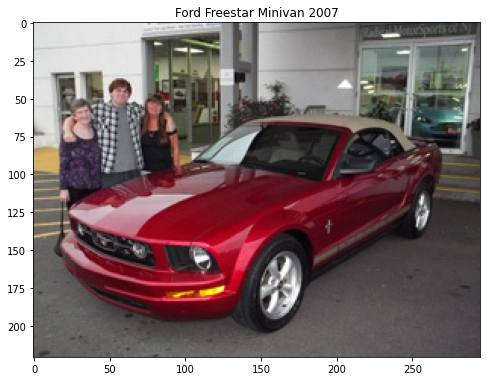

In [19]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

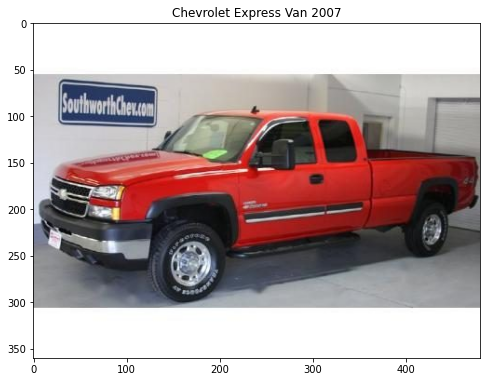

In [20]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

In [21]:
# Next Steps: 
# 1. Check data distribution
# 2. Create tensorflow input pipeline with normalization, conversion to grayscale
# 3. Use small images to find best suited cnn
# 4. Check different images sizes on winning cnn.
# 5. Apply data augmentation.
# 6. Apply Bayesian Hyperparameter Search to find best hyperparameters.
# 7. Plot Class Activation Maps.